In [ ]:
import numpy as np
import cv2
import pywt
from skimage.feature import local_binary_pattern
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [24]:
img = cv2.imread('002.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 1.
# Текстурные признаки Лавса
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(img, n_points, radius, method='uniform')

# Матрица взаимной встречаемости (GLCM)
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

# Признаки Фурье
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Вейвлет-признаки
coeffs2 = pywt.dwt2(img, 'bior1.3')
LL, (LH, HL, HH) = coeffs2

print(contrast, energy, homogeneity, correlation)

182.3389476841674 0.09776849715242995 0.44616328989049175 0.968895036885609


In [25]:
# Кодирование пикселей

encoded_img = np.zeros((img.shape[0], img.shape[1], 5), dtype=np.float32)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        encoded_img[i, j, 0] = lbp[i, j] # LBP
        encoded_img[i, j, 1] = contrast #GLCM
        encoded_img[i, j, 2] = magnitude_spectrum[i, j] # Фурье
        encoded_img[i, j, 3] = LL[i // 2, j // 2] # вейвлета (LL)
        encoded_img[i, j, 4] = np.mean(HH) # Среднее значение HH вейвлета

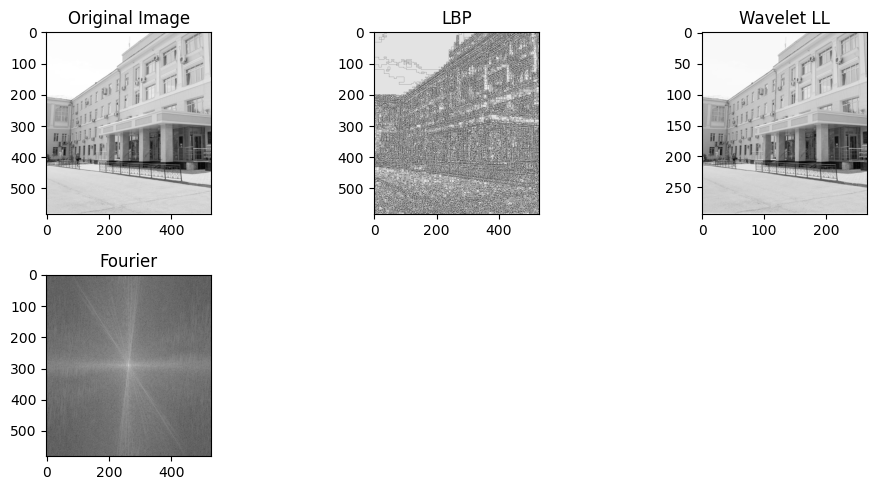

(582, 528, 5)


In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1), plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2), plt.imshow(lbp, cmap='gray')
plt.title('LBP')

plt.subplot(2, 3, 3), plt.imshow(LL, cmap='gray')
plt.title('Wavelet LL')

plt.subplot(2, 3, 4), plt.imshow(encoded_img[:,:,2], cmap='gray')
plt.title('Fourier')

plt.tight_layout()
plt.show()

print(encoded_img.shape)

In [5]:
print(encoded_img[:5, :5, :])

[[[ 3.00000000e+00  1.82338943e+02  1.39452118e+02  5.04000000e+02
   -6.24214113e-03]
  [ 5.00000000e+00  1.82338943e+02  1.19172913e+02  5.04000000e+02
   -6.24214113e-03]
  [ 5.00000000e+00  1.82338943e+02  1.35080093e+02  5.04000000e+02
   -6.24214113e-03]
  [ 5.00000000e+00  1.82338943e+02  1.38645233e+02  5.04000000e+02
   -6.24214113e-03]
  [ 5.00000000e+00  1.82338943e+02  1.27799194e+02  5.04000000e+02
   -6.24214113e-03]]

 [[ 5.00000000e+00  1.82338943e+02  1.45245178e+02  5.04000000e+02
   -6.24214113e-03]
  [ 8.00000000e+00  1.82338943e+02  1.36624374e+02  5.04000000e+02
   -6.24214113e-03]
  [ 8.00000000e+00  1.82338943e+02  1.37629501e+02  5.04000000e+02
   -6.24214113e-03]
  [ 8.00000000e+00  1.82338943e+02  9.07668686e+01  5.04000000e+02
   -6.24214113e-03]
  [ 8.00000000e+00  1.82338943e+02  1.29021240e+02  5.04000000e+02
   -6.24214113e-03]]

 [[ 5.00000000e+00  1.82338943e+02  1.38869461e+02  5.04000000e+02
   -6.24214113e-03]
  [ 8.00000000e+00  1.82338943e+02  1.4

In [27]:
# 2. Сегментация
img_orig = cv2.imread('002.JPG')
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

In [15]:
# K-means
flags = cv2.KMEANS_RANDOM_CENTERS
z = img.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

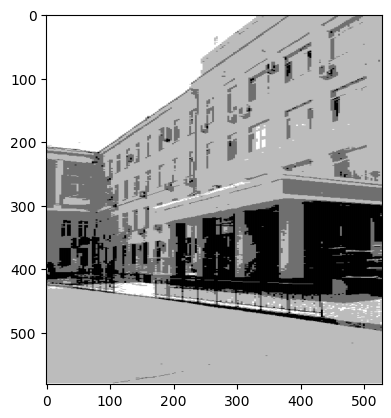

In [16]:
plt.imshow(res2, cmap="gray")
plt.show()

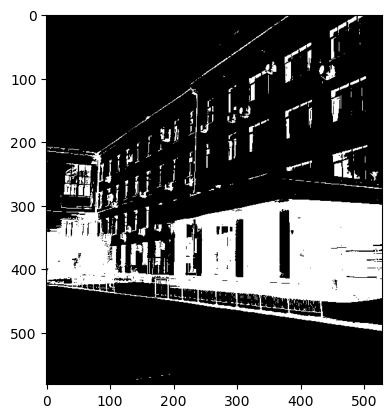

In [10]:
# Watershed+Distance transform
ret, thresh = cv2.threshold(img,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

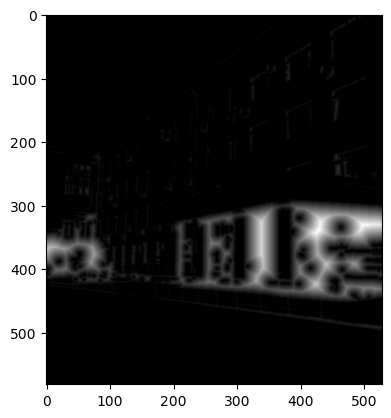

In [11]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

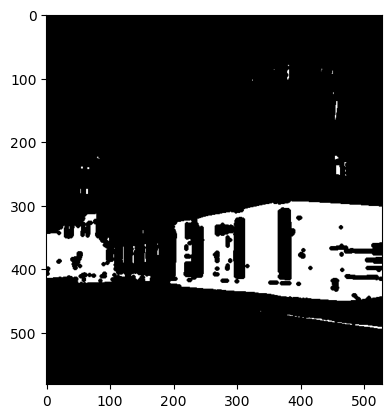

In [12]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

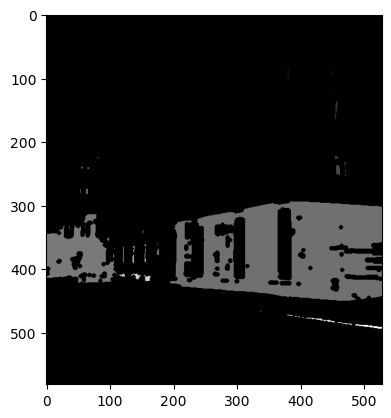

In [13]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers, cmap="gray")

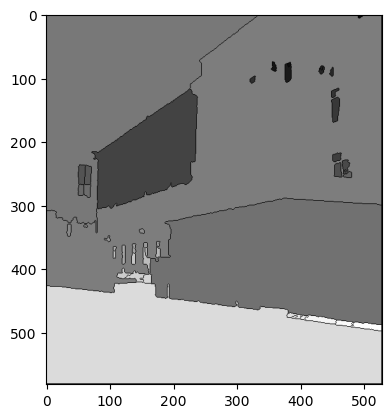

In [14]:
markers = cv2.watershed(img_orig, markers)
plt.imshow(markers, cmap="gray")

In [ ]:
# Разрастание регионов
def region_growing(image, seed_point, threshold):
    rows, cols = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    segmented[seed_point] = 1
    current_points = [seed_point]
    mean_intensity = image[seed_point]
    while current_points:
        new_points = []
        for x, y in current_points:
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols and segmented[nx, ny] == 0:
                        diff = abs(image[nx, ny] - mean_intensity)
                        if diff <= threshold:
                            segmented[nx, ny] = 1
                            new_points.append((nx, ny))
        if new_points:
            mean_intensity = np.mean(image[segmented == 1])
            current_points = new_points
        else:
            break

    return segmented * 255

seed_point = (500, 100)
threshold = 10

mask = region_growing(img, seed_point, threshold)

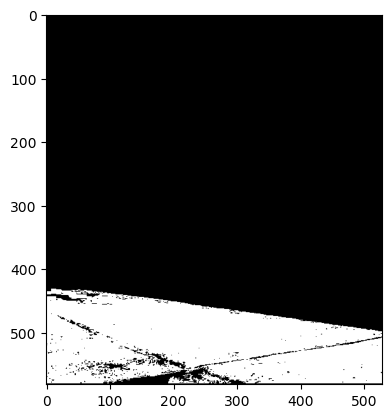

In [29]:
plt.imshow(mask, cmap="gray")
plt.show()